In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install openpyxl
!pip install mysql-connector-python
import mysql.connector
!pip install sqlalchemy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import resample
from sqlalchemy import create_engine
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 27.4 MB/s eta 0:00:00


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Exploratory Data Analysis

In [3]:
db_config = {
    'user': 'analyst',
    'password': '!analyst#ftw*',
    'host': 'data-analysis.ftwcr.com',
    'database': 'app_main'
}

try:
    conn = mysql.connector.connect(**db_config)
    if conn.is_connected():
        cursor = conn.cursor()
        cursor.execute("SHOW TABLES")
        tables = cursor.fetchall()

        print("Tables in the 'app_main' database:")
        for table in tables:
            print(table[0])

        cursor.close()
        conn.close()
except mysql.connector.Error as err:
    print(f"Error: {err}")


Tables in the 'app_main' database:
app_user_apprentice_checklist
app_user_checklist
app_user_subscription_status
app_users
hero_areas
hero_daily_challenges
hero_stats
payment_history
write_streaks
write_wordcount


## app_users Table

Number of duplicate rows in app_users: 0
Preview of the dataset:
   id  idhero           expires_at          created_at   status subscription_status
0   1       1  2299-07-25 17:36:34 2017-12-07 22:55:35    sleep          subscriber
1  14    3799  2019-11-11 23:59:59 2017-03-16 09:13:53    sleep         unconverted
2  21    3804  2019-11-11 23:59:59 2016-05-16 09:13:53    sleep         unconverted
3  22    3805  2024-06-16 11:12:23 2016-05-16 09:13:53  veteran          subscriber
4  28      28  2060-03-02 17:52:22 2016-05-16 09:13:53  veteran          subscriber

Basic Statistics:
                 id        idhero                     created_at
count  68882.000000  68882.000000                          68882
mean   35821.185375  36942.607575  2021-01-09 04:07:52.048024320
min        1.000000      1.000000            2016-05-16 09:13:53
25%    17821.250000  19088.250000     2018-10-05 23:13:29.500000
50%    35748.500000  37019.500000     2021-05-10 13:35:56.500000
75%    53480.750000  5

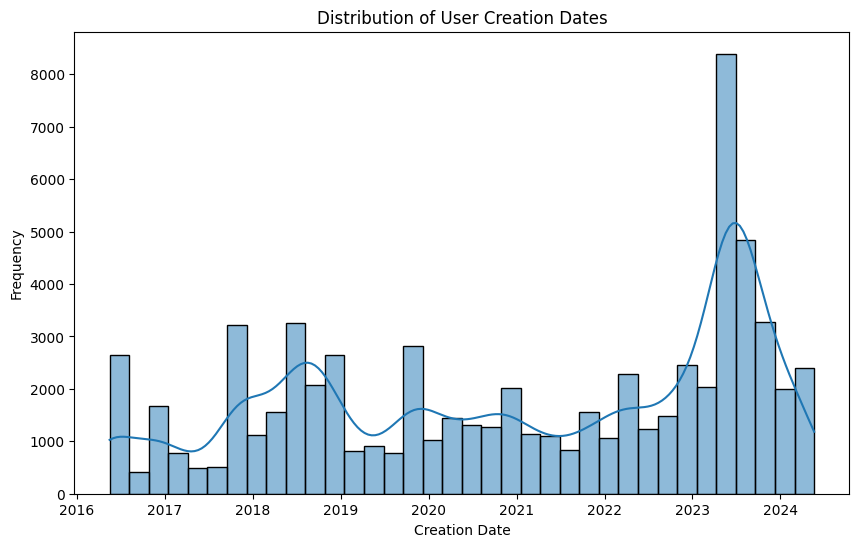

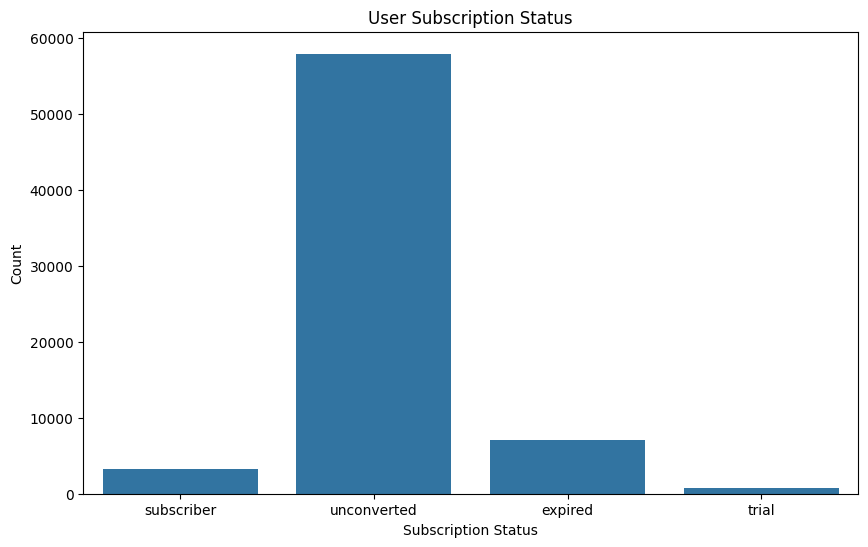

In [4]:
conn = mysql.connector.connect(**db_config)

def load_data(query):
    cursor = conn.cursor(dictionary=True)
    cursor.execute(query)
    data = cursor.fetchall()
    cursor.close()
    return pd.DataFrame(data)

app_users_df = load_data("SELECT * FROM app_users")

app_users_df = app_users_df.drop(columns=['referred_by'])

# Check for duplicates
duplicates = app_users_df[app_users_df.duplicated()]
print(f"Number of duplicate rows in app_users: {len(duplicates)}")

# If there are duplicates, remove them
if len(duplicates) > 0:
    app_users_df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

# Display the first few rows of the dataset
print("Preview of the dataset:")
print(app_users_df.head())

# Basic statistics
print("\nBasic Statistics:")
print(app_users_df.describe())

# Check for missing values
print("\nMissing Values:")
print(app_users_df.isnull().sum())

# Visualization: Distribution of created_at dates
plt.figure(figsize=(10, 6))
sns.histplot(pd.to_datetime(app_users_df['created_at']), kde=True)
plt.title('Distribution of User Creation Dates')
plt.xlabel('Creation Date')
plt.ylabel('Frequency')
plt.show()

# Visualization: Countplot of subscription status
plt.figure(figsize=(10, 6))
sns.countplot(data=app_users_df, x='subscription_status')
plt.title('User Subscription Status')
plt.xlabel('Subscription Status')
plt.ylabel('Count')
plt.show()

conn.close()

Chart 1: Distribution of User Creation Dates
Description:
This histogram illustrates the frequency of creating user accounts over time. The number of users created is plotted on the y-axis, while the creation dates are plotted on the x-axis.

Analysis:
1. The period of creation is from 2016 to 2024. A noticeable spike in user creation occurs around late 2022 to early 2023, suggesting a period of increased user registration. Given that most of the accounts were opened within the last few years, the distribution seems to be skewed to the right. This pattern implies that the platform has grown in popularity and user base over time.

Chart 2: User Subscription Status
Description:
Users are counted according to their subscription status in this bar chart. Different subscription statuses (unconverted, subscriber, expired, trial) are represented by the x-axis, and the number of users in each category is represented by the y-axis.

Analysis:
1. Most users do not convert to paid subscriptions; most users who sign up fall into the "unconverted" category. This shows that there is a big chance to raise the conversion rate.
2. A reduced percentage of users fall into the "subscriber" group, signifying those who make payments.
3. There are also not many entries in the "trial" and "expired" categories. Individuals falling into these groups could be prospects for conversion, either through bringing back inactive users or turning trial users into subscribers.
4. Techniques could center on figuring out why users don't convert and putting policies in place to entice more people to sign up.

### Retention Analysis

<ipython-input-5-629cede22823>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_users_df['retention_days'] = (app_users_df['expires_at'] - app_users_df['created_at']).dt.days


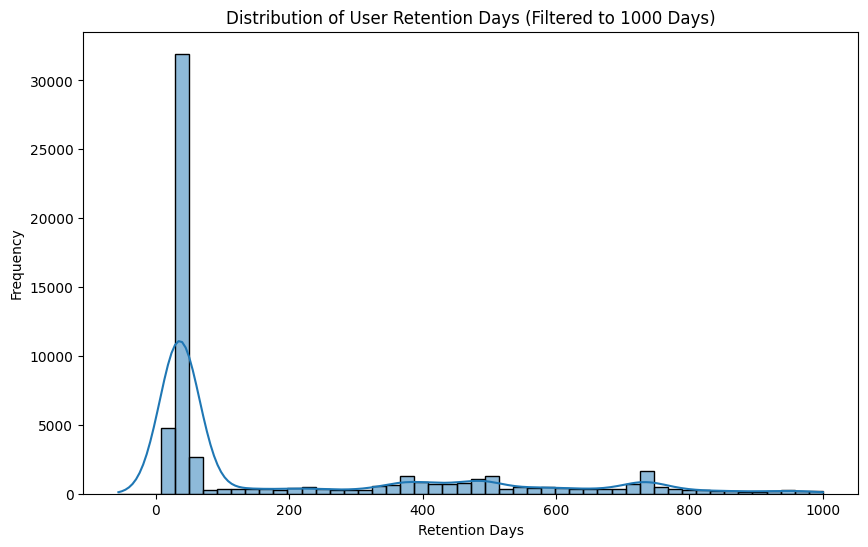

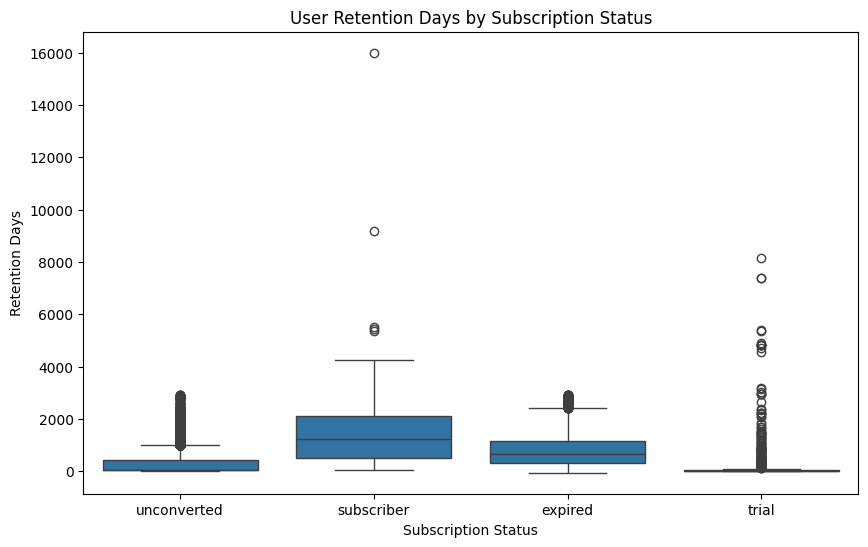

In [5]:
def clean_datetime(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce')
    # Remove dates that are too far in the future or past
    max_date = pd.Timestamp('2100-01-01')
    min_date = pd.Timestamp('2000-01-01')
    df.loc[df[column_name] > max_date, column_name] = pd.NaT
    df.loc[df[column_name] < min_date, column_name] = pd.NaT
    return df

# Clean the created_at and expires_at columns
app_users_df = clean_datetime(app_users_df, 'created_at')
app_users_df = clean_datetime(app_users_df, 'expires_at')

# Drop rows with NaT in created_at or expires_at
app_users_df = app_users_df.dropna(subset=['created_at', 'expires_at'])

# Calculate user retention days
app_users_df['retention_days'] = (app_users_df['expires_at'] - app_users_df['created_at']).dt.days

# Filter for retention days <= 1000
df_filtered = app_users_df[app_users_df['retention_days'] <= 1000]

# Plot the distribution of retention days (filtered)
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['retention_days'], kde=True, bins=50)
plt.title('Distribution of User Retention Days (Filtered to 1000 Days)')
plt.xlabel('Retention Days')
plt.ylabel('Frequency')
plt.show()

# Boxplot of retention days by subscription status
plt.figure(figsize=(10, 6))
sns.boxplot(data=app_users_df, x='subscription_status', y='retention_days')
plt.title('User Retention Days by Subscription Status')
plt.xlabel('Subscription Status')
plt.ylabel('Retention Days')
plt.show()


Chart 3: Distribution of User Retention Days
Description
The distribution of user retention days is shown in the chart, which has been filtered to show only users with retention days of 1000 days or fewer.

Analysis
1. The most prominent feature in the chart is the high frequency of users with very low retention days, particularly clustering around the very beginning of the retention period (0-30 days). This implies that shortly after a user joins up or begins using the service, there appears to be a noticeable decline in user retention.

2. Following the first drop-off, there is a sharp decline in frequency followed by a lengthy tail that can last up to 1000 days. This suggests that a smaller percentage of users stay engaged for noticeably longer periods of time, even though the majority of users do not stay long.

3. The chart suggests that strategies to improve retention should particularly focus on the early days of user engagement. Reducing the initial drop-off could substantially increase overall retention.

Chart 4: User Retention Days by Subscription Status
Description
A box plot of user retention days broken down by subscription status is shown in the chart. One can find the following categories: "unconverted," "subscriber," "expired," and "trial."

Analysis
1. Unconverted Users:
Median Retention: The extremely low median retention for non-converting users suggests that the majority of them quit the platform before it becomes profitable.

2. Subscribers:
Median Retention: Compared to other groups, subscribers have a significantly higher median retention, indicating a correlation between subscribing and extended platform engagement.

3. Expired Users:
Median Retention: The median retention for expired users is higher than unconverted but lower than subscribers.

4. Trial Users:
Median Retention: Trial users have a very low median retention, similar to unconverted users, suggesting that many trial users do not convert to long-term users.

### Status Analysis

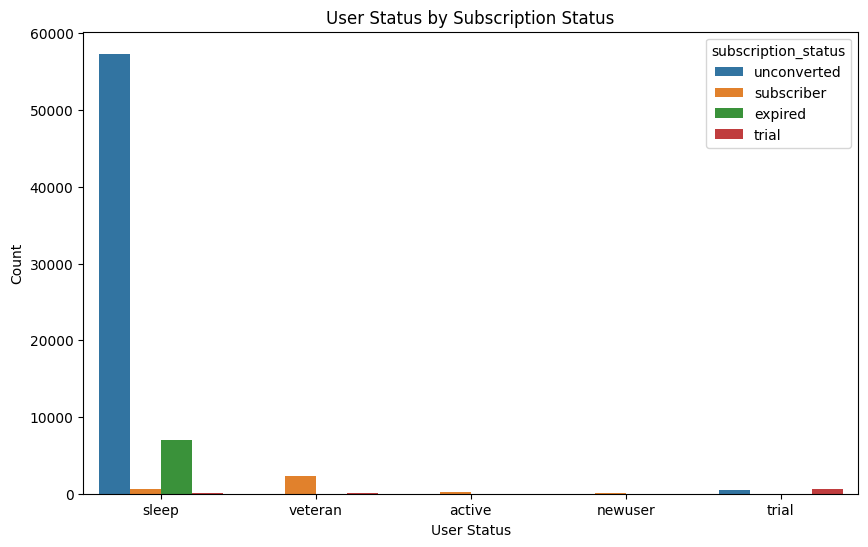

In [6]:
# User status by subscription status
plt.figure(figsize=(10, 6))
sns.countplot(data=app_users_df, x='status', hue='subscription_status')
plt.title('User Status by Subscription Status')
plt.xlabel('User Status')
plt.ylabel('Count')
plt.show()


Chart 5: User Status by Subscription Status
Description:
The number of user statuses sorted by subscription status is displayed in this bar graph. The y-axis shows the number of users in each category, while the x-axis shows the various user statuses (sleep, veteran, active, newuser, trial).

Analysis:
1. Most unconverted users are in the "sleep" status, meaning they are inactive or disengaged. This indicates a need for re-engagement strategies to convert these users.
2. Subscribers are more likely to be in the "veteran" or "active" statuses, showing that paying users tend to be more engaged and stay longer.
3. "Newuser" and "trial" statuses have fewer counts but represent potential areas for targeted onboarding and conversion efforts.

### Subscription Status Over Time

<Figure size 1400x700 with 0 Axes>

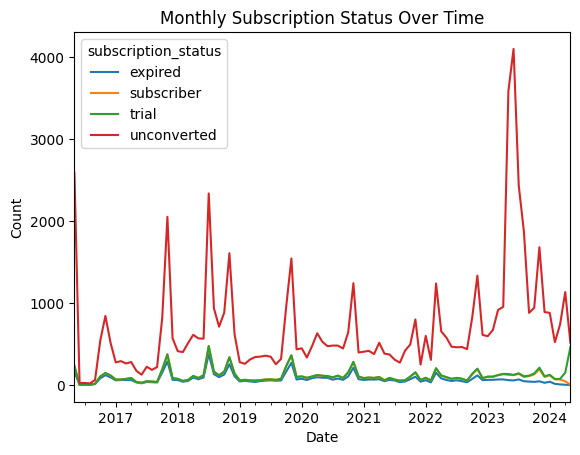

In [7]:
# Resample data by month
app_users_df.set_index('created_at', inplace=True)
monthly_subscriptions = app_users_df.resample('M').subscription_status.value_counts().unstack().fillna(0)

# Plot the monthly subscription statuses
plt.figure(figsize=(14, 7))
monthly_subscriptions.plot(kind='line', stacked=True)
plt.title('Monthly Subscription Status Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()


Chart 6: Monthly Subscription Status Over Time
Description:
This line chart shows the count of different subscription statuses over time, resampled monthly. The x-axis represents the date, and the y-axis represents the count of users in each subscription status.

Analysis:
1. Users who have not converted exhibit the greatest fluctuation over time, with observable peaks that may be associated with particular occasions, advertising campaigns, or seasonal patterns.
2. The counts of other statuses (expired, subscriber, trial) are relatively stable but low in comparison to unconverted users.

## app_user_apprentice_checklist Table

In [8]:
conn = mysql.connector.connect(**db_config)

query = "SELECT * FROM app_user_apprentice_checklist"
app_user_apprentice_checklist_df = pd.read_sql(query, conn)

conn.close()

# Check for duplicates
duplicates = app_user_apprentice_checklist_df[app_user_apprentice_checklist_df.duplicated()]
print(f"Number of duplicate rows in app_user_apprentice_checklist: {len(duplicates)}")

# If there are duplicates, remove them
if len(duplicates) > 0:
    app_user_apprentice_checklist_df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

# Display the first few rows of the dataset
print("app_user_apprentice_checklist")
print(app_user_apprentice_checklist_df.head())

# Basic statistics
print("\nBasic Statistics for app_user_apprentice_checklist:")
print(app_user_apprentice_checklist_df.describe())

# Check for missing values
print("\nMissing Values in app_user_apprentice_checklist:")
print(app_user_apprentice_checklist_df.isnull().sum())


Number of duplicate rows in app_user_apprentice_checklist: 8
Duplicates removed.
app_user_apprentice_checklist
   idchallenge  iduser          created_at          updated_at
0          102   70470 2024-03-14 10:48:16 2024-03-14 10:48:16
1          102   70265 2024-03-14 10:48:20 2024-03-14 10:48:20
2          102   69784 2024-03-14 10:48:28 2024-03-14 10:48:28
3          102   70511 2024-03-14 10:48:30 2024-03-14 10:48:30
4          102   70807 2024-03-14 10:48:39 2024-03-14 10:48:39

Basic Statistics for app_user_apprentice_checklist:
       idchallenge        iduser                     created_at                     updated_at
count  2170.000000   2170.000000                           2170                           2170
mean    102.129493  70054.844700  2024-04-11 18:40:42.523502336  2024-04-11 18:40:42.523502336
min     101.000000  45253.000000            2024-03-14 10:48:16            2024-03-14 10:48:16
25%     101.000000  70853.000000  2024-03-27 13:51:06.249999872  2024-03-27 13

<ipython-input-8-5b6058ca6892>:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  app_user_apprentice_checklist_df = pd.read_sql(query, conn)


## app_user_checklist Table

In [9]:
conn = mysql.connector.connect(**db_config)

query = "SELECT * FROM app_user_checklist"
app_user_checklist_df = pd.read_sql(query, conn)

conn.close()

# Check for duplicates
duplicates = app_user_checklist_df[app_user_checklist_df.duplicated()]
print(f"Number of duplicate rows in app_user_checklist: {len(duplicates)}")

# If there are duplicates, remove them
if len(duplicates) > 0:
    app_user_checklist_df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

# Display the first few rows of the dataset
print("app_user_checklist")
print(app_user_checklist_df.head())

# Basic statistics
print("\nBasic Statistics for app_user_checklist:")
print(app_user_checklist_df.describe())

# Check for missing values
print("\nMissing Values in app_user_checklist:")
print(app_user_checklist_df.isnull().sum())

<ipython-input-9-63acb5dd3914>:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  app_user_checklist_df = pd.read_sql(query, conn)


Number of duplicate rows in app_user_checklist: 0
app_user_checklist
   id  iduser  tear                                              steps  completed  \
0   1   37245     2  {"t1s1":true,"t1s2":true,"t1s3":true,"t2s1":tr...          1   
1   2   63106     2  {"t1s1":true,"t1s2":true,"t1s3":true,"t2s1":tr...          0   
2   3   63108     2  {"t1s1":true,"t1s2":true,"t1s3":true,"t2s1":tr...          1   
3   4   63110     2  {"t1s1":true,"t1s2":true,"t1s3":true,"t2s1":tr...          0   
4   5   63112     2  {"t1s1":true,"t1s2":true,"t1s3":true,"t2s1":tr...          0   

           updated_at          created_at  
0 2023-09-19 17:57:33 2023-09-19 10:34:33  
1 2023-09-19 11:20:29 2023-09-19 10:43:07  
2 2023-09-19 10:55:45 2023-09-19 10:46:55  
3 2023-09-19 11:24:51 2023-09-19 11:00:56  
4 2023-09-19 17:40:08 2023-09-19 11:21:53  

Basic Statistics for app_user_checklist:
                 id        iduser          tear     completed                     updated_at  \
count  14068.00000

### Correlation Analysis

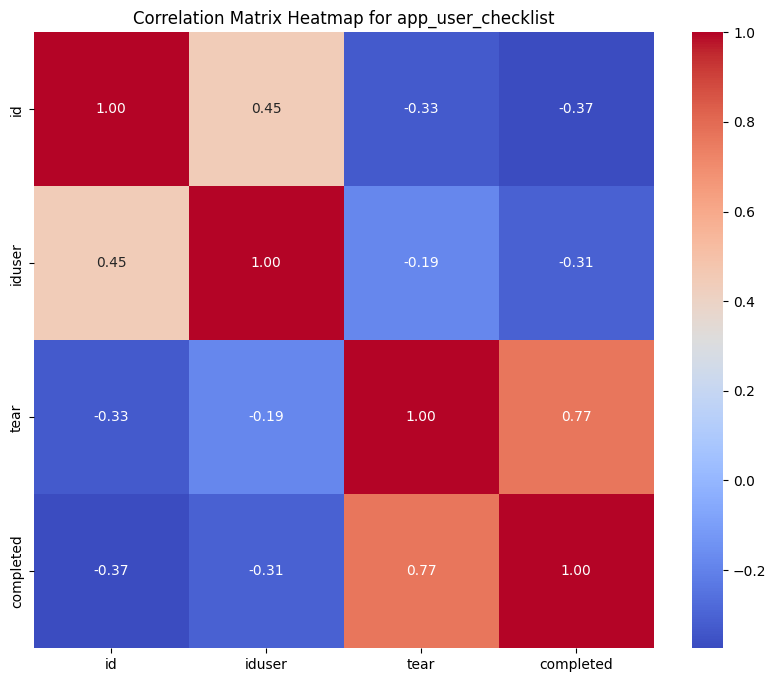

In [10]:
# Select only numeric columns for correlation analysis
numeric_cols = app_user_checklist_df.select_dtypes(include=['number']).columns
numeric_df = app_user_checklist_df[numeric_cols]

# Display correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap for app_user_checklist')
plt.show()


Chart 7: Correlation Matrix Heatmap for app_user_checklist
Description:
This heatmap visualizes the correlation between different variables in the app_user_checklist table. The variables included are id, iduser, tear, and completed. The correlation values range from -1 to 1, where 1 implies a perfect positive correlation, -1 implies a perfect negative correlation, and 0 implies no correlation.

Analysis:
1. tear vs. completed (0.77):
Higher completed values are correlated with higher tear values, as evidenced by this strong positive correlation. According to this relationship, users who have higher tear values also probably finish more checklists.

## app_user_subscription_status Table

In [11]:
conn = mysql.connector.connect(**db_config)

query = "SELECT * FROM app_user_subscription_status"
app_user_subscription_status_df = pd.read_sql(query, conn)

conn.close()

# Check for duplicates
duplicates = app_user_subscription_status_df[app_user_subscription_status_df.duplicated()]
print(f"Number of duplicate rows in app_user_subscription_status: {len(duplicates)}")

# If there are duplicates, remove them
if len(duplicates) > 0:
    app_user_subscription_status_df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

# Display the first few rows of the dataset
print("app_user_subscription_status")
print(app_user_subscription_status_df.head())

# Basic statistics
print("\nBasic Statistics for app_user_subscription_status:")
print(app_user_subscription_status_df.describe())

# Check for missing values
print("\nMissing Values in app_user_subscription_status:")
print(app_user_subscription_status_df.isnull().sum())

Number of duplicate rows in app_user_subscription_status: 0
app_user_subscription_status
   id                date  trial_total  unconverted_total  subscriber_total  expired_total  \
0   1 2024-05-09 16:23:56          889              57485              3232           7012   
1   2 2024-05-10 00:00:33          874              57501              3233           7010   
2   3 2024-05-11 00:00:47          864              57538              3236           7009   
3   4 2024-05-12 00:00:09          841              57580              3232           7015   
4   5 2024-05-13 00:00:28          828              57622              3218           7029   

   converted  lost_conversion  resurrected  lost  expired          updated_at          created_at  
0          0                0            0     0        0 2024-05-09 10:23:56 2024-05-09 10:23:56  
1          0                0           11    18       10 2024-05-09 18:00:33 2024-05-09 18:00:33  
2          0                2           14    

<ipython-input-11-74a9e821a590>:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  app_user_subscription_status_df = pd.read_sql(query, conn)


## hero_areas Table

In [12]:
conn = mysql.connector.connect(**db_config)

query = "SELECT * FROM hero_areas"
hero_areas_df = pd.read_sql(query, conn)

conn.close()

# Check for duplicates
duplicates = hero_areas_df[hero_areas_df.duplicated()]
print(f"Number of duplicate rows in hero_areas: {len(duplicates)}")

# If there are duplicates, remove them
if len(duplicates) > 0:
    hero_areas_df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

# Display the first few rows of the dataset
print("hero_areas")
print(hero_areas_df.head())

# Basic statistics
print("\nBasic Statistics for hero_areas:")
print(hero_areas_df.describe())

# Check for missing values
print("\nMissing Values in hero_areas:")
print(hero_areas_df.isnull().sum())


<ipython-input-12-1cd42fab03ac>:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hero_areas_df = pd.read_sql(query, conn)


Number of duplicate rows in hero_areas: 0
hero_areas
   idheroarea  idarea  idhero  iduser  active          created_at          updated_at  \
0        1558       1    3799     NaN       1 2016-11-04 07:34:05 2017-05-09 01:03:36   
1        1564       1    3804     NaN       1 2016-11-04 07:34:06 2017-05-09 01:03:36   
2        1565       1    3805     NaN       1 2016-11-04 07:34:06 2017-05-09 01:03:36   
3        1566       1      28    28.0       0 2016-05-17 01:56:53 2020-07-28 08:23:32   
4        1575       1    3806     NaN       1 2016-11-04 07:34:06 2017-05-09 01:03:36   

  freeze_until  freeze_cost  freeze_relation  freeze_origin  step  unlocked  introduction  
0          NaT          NaN              NaN            NaN     8         1             0  
1          NaT          NaN              NaN            NaN     8         1             0  
2          NaT          NaN              NaN            NaN     8         1             0  
3          NaT          NaN              NaN

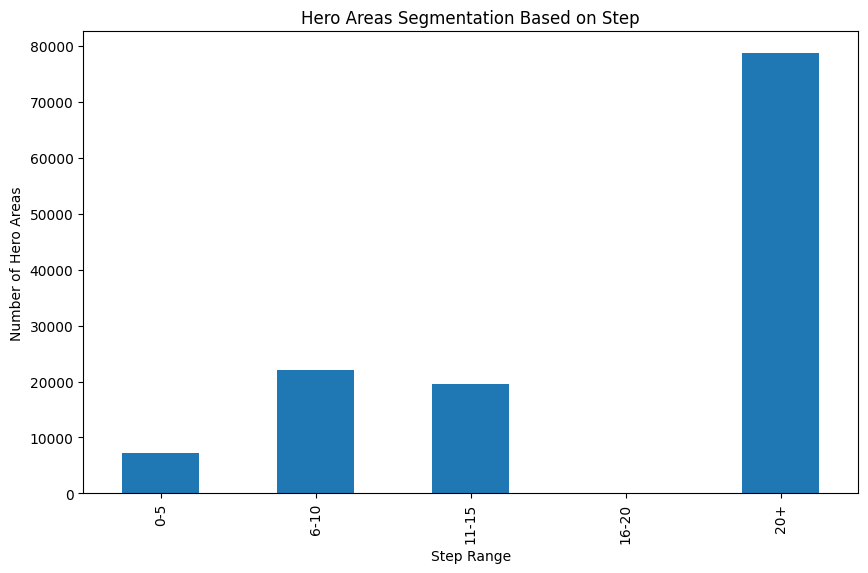

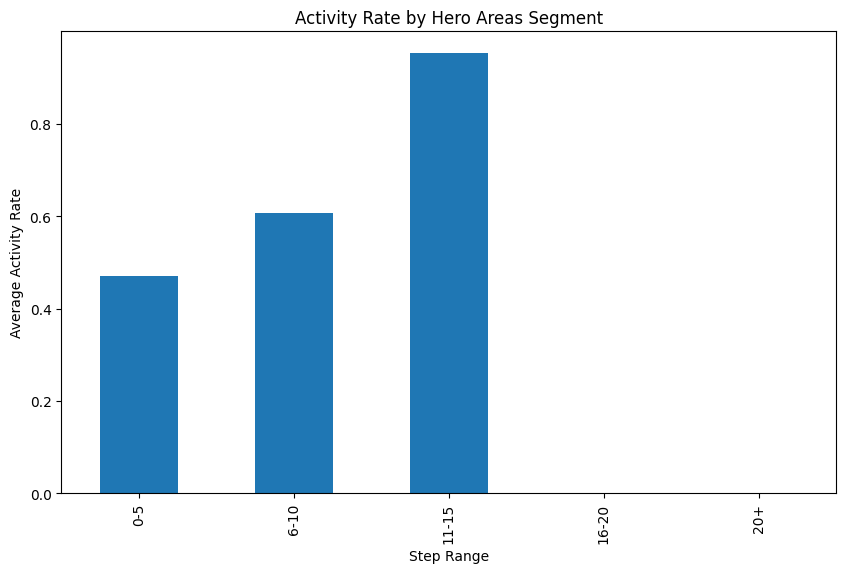

In [13]:
# Segment hero areas based on the 'step' attribute
segments = pd.cut(hero_areas_df['step'], bins=[0, 5, 10, 15, 20, float('inf')], labels=['0-5', '6-10', '11-15', '16-20', '20+'])

# Plot the distribution of segments
plt.figure(figsize=(10, 6))
segments.value_counts().sort_index().plot(kind='bar')
plt.title('Hero Areas Segmentation Based on Step')
plt.xlabel('Step Range')
plt.ylabel('Number of Hero Areas')
plt.show()

# Analyze active status within segments
if 'active' in hero_areas_df.columns:
    segment_activity = hero_areas_df.groupby(segments)['active'].mean()
    plt.figure(figsize=(10, 6))
    segment_activity.plot(kind='bar')
    plt.title('Activity Rate by Hero Areas Segment')
    plt.xlabel('Step Range')
    plt.ylabel('Average Activity Rate')
    plt.show()
else:
    print("No 'active' column found in the dataset.")


Chart 8: Hero Areas Segmentation Based on Step
Description:
This bar chart segments hero areas based on the 'step' attribute. The x-axis represents the step numbers, and the y-axis represents the count of hero areas in each step.

Analysis:
1. Most hero areas fall within the lower step ranges, indicating that users tend to progress through the initial stages but may drop off as the steps increase.

Chart 9: Activity Rate by Hero Areas Segment
Description:
This bar chart shows the average activity rate for each hero area segment. The x-axis represents the step segments, and the y-axis represents the average activity rate.

Analysis:
1. Different segments have different activity rates, and some step ranges have higher engagement. Increased activity rates in lower steps indicate a high level of initial engagement, which may diminish in subsequent steps.


## hero_daily_challenges Table

In [14]:
conn = mysql.connector.connect(**db_config)

query = "SELECT * FROM hero_daily_challenges"
hero_daily_challenges_df = pd.read_sql(query, conn)

conn.close()

# Check for duplicates
duplicates = hero_daily_challenges_df[hero_daily_challenges_df.duplicated()]
print(f"Number of duplicate rows in hero_daily_challenges: {len(duplicates)}")

# If there are duplicates, remove them
if len(duplicates) > 0:
    hero_daily_challenges_df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

# Display the first few rows of the dataset
print("hero_daily_challenges")
print(hero_daily_challenges_df.head())

# Basic statistics
print("\nBasic Statistics for hero_daily_challenges:")
print(hero_daily_challenges_df.describe())

# Check for missing values
print("\nMissing Values in hero_daily_challenges:")
print(hero_daily_challenges_df.isnull().sum())

<ipython-input-14-c903ccaac921>:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hero_daily_challenges_df = pd.read_sql(query, conn)


Number of duplicate rows in hero_daily_challenges: 0
hero_daily_challenges
   id  idhero  iddailychallenge        date  completed          created_at          updated_at
0   1    1192                 1  2023-07-19          1 2023-07-19 16:44:44 2023-07-19 16:45:51
1   2    1192                 7  2023-07-19          1 2023-07-19 16:44:44 2023-07-19 16:45:05
2   3    1192                 2  2023-07-19          1 2023-07-19 16:44:44 2023-07-19 16:45:51
3   4    1192                 8  2023-07-19          1 2023-07-19 16:44:44 2023-07-19 16:45:07
4   5    1192                 3  2023-07-19          1 2023-07-19 16:44:44 2023-07-19 16:45:51

Basic Statistics for hero_daily_challenges:
                 id        idhero  iddailychallenge     completed                     created_at  \
count  5.256426e+06  5.256426e+06      5.256426e+06  5.256426e+06                        5256426   
mean   2.628214e+06  3.884273e+04      6.510696e+00  4.394406e-01  2023-12-21 16:34:23.945201664   
min    1.0

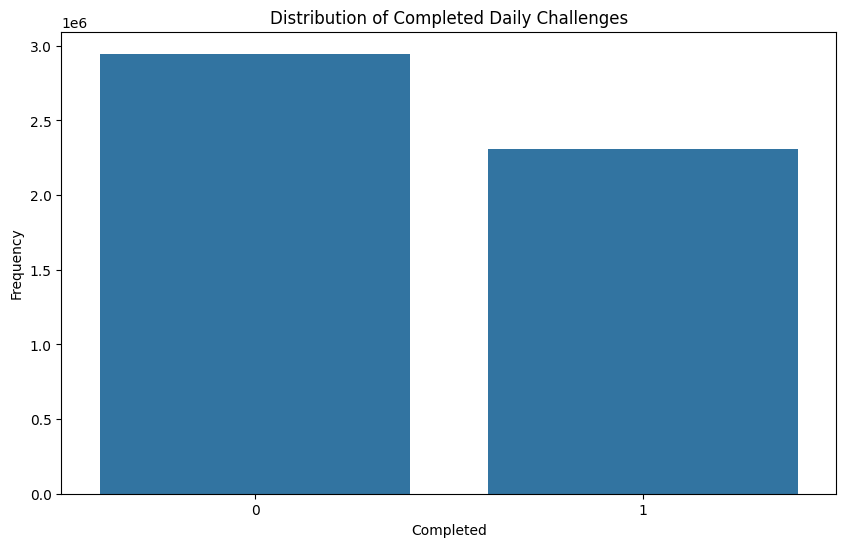

In [15]:
# Filter data to include only 0 and 1 in the 'completed' column
filtered_data = hero_daily_challenges_df[hero_daily_challenges_df['completed'].isin([0, 1])]

# Plot bar plot for 'completed' column
plt.figure(figsize=(10, 6))
sns.countplot(x='completed', data=filtered_data)
plt.title('Distribution of Completed Daily Challenges')
plt.xlabel('Completed')
plt.ylabel('Frequency')
plt.xticks([0, 1])
plt.show()


Chart 10: Distribution of Completed Daily Challenges
Description:
This bar chart visualizes the distribution of the completed status for daily challenges. The completed column in the hero_daily_challenges table can take on two values: 0 (not completed) and 1 (completed). The x-axis represents the completed status, and the y-axis represents the frequency of each status.

Analysis:
1. User Engagement:
Given the huge number of unfinished challenges, it is necessary to look into the reasons behind users' failure to complete their daily challenges. This might be the result of other problems with the user experience, too hard challenges, or insufficient engagement.
2. Improvement Areas:
It could be advantageous to add features or rewards that motivate users to finish their challenges in order to raise the completion rate. Giving more attractive incentives, for instance, for finishing a specific number of daily challenges in a row could raise engagement.

## payment_history Table


<ipython-input-16-f3a543cf3d96>:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  payment_history_df = pd.read_sql(query, conn)


Number of duplicate rows in payment_history: 0
payment_history
   idpayment  method  amount  iduser  confirmed          created_at
0          5  paypal     4.0   834.0          1 2016-09-07 14:22:12
1          6   items    44.0   834.0          1 2016-09-07 14:22:43
2          7  paypal     4.0  1440.0          1 2016-09-13 06:28:05
3          8  paypal     0.0  1440.0          1 2016-09-13 06:46:54
4         10   items    44.0  2027.0          1 2016-09-13 08:01:13

Basic Statistics for payment_history:
           idpayment         amount         iduser      confirmed                     created_at
count  106445.000000  106445.000000  106325.000000  106445.000000                         106445
mean    54405.993847      66.114639   22928.432589       0.928169  2021-03-26 17:30:55.191629568
min         5.000000       0.000000       1.000000       0.000000            2016-09-07 14:22:12
25%     27038.000000       4.000000   10208.000000       1.000000            2019-09-26 21:28:10
50%  

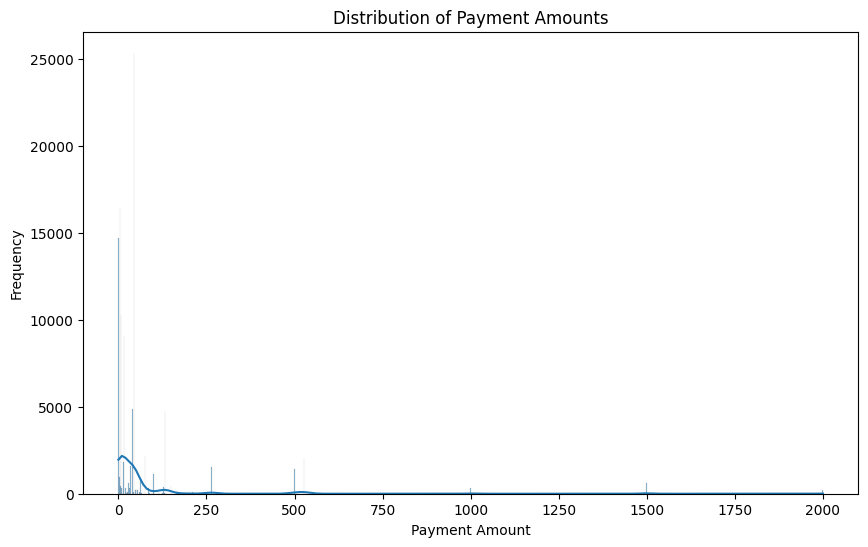

In [16]:
conn = mysql.connector.connect(**db_config)

query = "SELECT * FROM payment_history"
payment_history_df = pd.read_sql(query, conn)

conn.close()

# Check for duplicates
duplicates = payment_history_df[payment_history_df.duplicated()]
print(f"Number of duplicate rows in payment_history: {len(duplicates)}")

# If there are duplicates, remove them
if len(duplicates) > 0:
    payment_history_df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

# Display the first few rows of the dataset
print("payment_history")
print(payment_history_df.head())

print("\nBasic Statistics for payment_history:")
print(payment_history_df.describe())

# Check for missing values
print("\nMissing Values in payment_history:")
print(payment_history_df.isnull().sum())

payment_history_cleaned = payment_history_df.dropna(subset=['iduser'])

# Visualization: Distribution of payment amounts
plt.figure(figsize=(10, 6))
sns.histplot(payment_history_cleaned['amount'], kde=True)
plt.title('Distribution of Payment Amounts')
plt.xlabel('Payment Amount')
plt.ylabel('Frequency')
plt.show()


Chart 11: Distribution of Payment Amounts
Description:
This histogram visualizes the distribution of payment amounts from the payment_history table. The x-axis represents the payment amount, and the y-axis represents the frequency of each payment amount.

Analysis:
1. The frequency of payments decreases noticeably as the amount increases, with the frequency of payments decreasing significantly as the amount increases.
2. With a few payments at higher amounts, the bulk of payment amounts are distributed around the lower values.
3. Therefore, the data suggests that users tend to make smaller payments more frequently.
4. Given the high frequency of small payments, it might be beneficial to offer more low-cost options or microtransactions to cater to the majority of users who prefer smaller payments.
5. Consider offering discounts or bonuses for bulk purchases or higher payment amounts to encourage users to spend more.


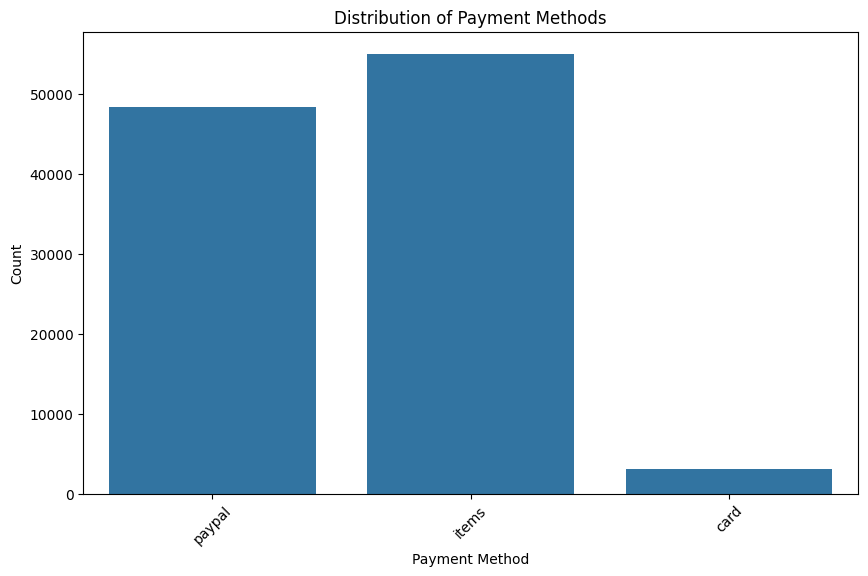

In [17]:
# Plot the distribution of payment methods
plt.figure(figsize=(10, 6))
sns.countplot(x='method', data=payment_history_cleaned)
plt.title('Distribution of Payment Methods')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Chart 12: Distribution of Payment Methods
Description:
This bar chart visualizes the distribution of different payment methods used in the payment_history table. The x-axis represents the payment methods, and the y-axis represents the count or frequency of each payment method.

Analysis:
1. The payment methods "items" and "paypal" are the most frequently used methods, with "items" having a slightly higher count than "paypal". Both methods are significantly more common than "card" and "money".
2. Given the dominance of "items" and "paypal", efforts should be made to ensure these payment methods are as easy to use and seamless as possible. Any issues in these processes should be addressed promptly.

## write_streaks Table

In [18]:
conn = mysql.connector.connect(**db_config)

query = "SELECT * FROM write_streaks"
write_streaks_df = pd.read_sql(query, conn)

conn.close()

# Check for duplicates
duplicates = write_streaks_df[write_streaks_df.duplicated()]
print(f"Number of duplicate rows in write_streaks: {len(duplicates)}")

# Remove duplicates
if len(duplicates) > 0:
    write_streaks_df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

print("write_streaks")
print(write_streaks_df.head())

print("\nBasic Statistics for write_streaks:")
print(write_streaks_df.describe())

# Check for missing values
print("\nMissing Values in write_streaks:")
print(write_streaks_df.isnull().sum())

<ipython-input-18-d860e7a557db>:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  write_streaks_df = pd.read_sql(query, conn)


Number of duplicate rows in write_streaks: 0
write_streaks
   idstreak  iduser  count  start_date    end_date
0         1      28      2  2015-11-23  2015-11-24
1         2      28      2  2015-11-30  2015-12-01
2         3      28      2  2015-12-11  2015-12-14
3         4     133      5  2015-11-23  2015-11-28
4         5     133      2  2015-12-06  2015-12-07

Basic Statistics for write_streaks:
            idstreak         iduser          count
count  192188.000000  192188.000000  192188.000000
mean   131281.771354   26800.030725      15.744511
std     80447.508280   17166.568734     116.922559
min         1.000000      14.000000       1.000000
25%     60999.750000   13469.000000       1.000000
50%    128227.500000   24854.000000       1.000000
75%    201177.250000   37649.000000       3.000000
max    274097.000000   73021.000000    3102.000000

Missing Values in write_streaks:
idstreak      0
iduser        0
count         0
start_date    0
end_date      0
dtype: int64


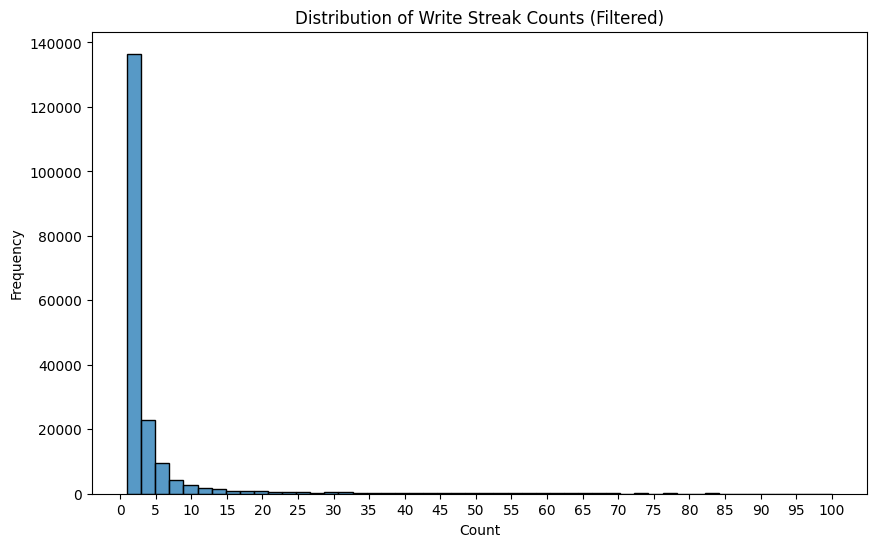

In [19]:
# Set a threshold to filter out outliers
threshold = 100

# Filter the data
filtered_data = write_streaks_df[write_streaks_df['count'] <= threshold]

# Plot distribution of 'count' for the filtered data
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['count'], kde=False, bins=50)
plt.title('Distribution of Write Streak Counts (Filtered)')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.xticks(range(0, threshold + 1, 5))  # Set x-axis ticks to show more detail
plt.show()


Chart 13: Distribution of Write Streak Counts (Filtered)
Description:
This histogram displays the distribution of write streak counts for users, filtered to show counts up to 100 days. The x-axis represents the number of days in a write streak, and the y-axis represents the frequency of users achieving those streak counts.

Analysis:
1. The chart shows that the majority of users have short write streaks. The most common streak length is very short, with a steep drop-off after just a few days. This suggests that users tend to write consistently for a few days but struggle to maintain longer streaks.
2. The streak count has a notable peak at the lower end (0–5 days), suggesting that many users are unable to continue writing on a streak longer than this.
3. As the streak length increases, the number of users maintaining those streaks decreases drastically. Very few users have streaks longer than 10 days, and almost none have streaks longer than 20 days. This pattern might indicate the need for better incentives or support to help users maintain longer writing streaks.

Insights:
1. Incentivize Longer Streaks: Adding more gamification components to the platform, like krystals, awards, or badges, can encourage users to write more frequently.
2. Personalized Support: Offering personalized feedback, tips, or encouragement when users are close to breaking their streak might help in sustaining their writing habits.
3. Community Engagement: Encouraging users to join writing groups or challenges can create a sense of accountability and support, making it easier for them to maintain longer streaks.

## write_wordcount Table

<ipython-input-20-ad5f5946a0dc>:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  write_wordcount_df = pd.read_sql(query, conn)


Number of duplicate rows in write_wordcount: 0
write_wordcount
   idwordcount  iduser  words  display_words  penalty  minutes  display_minutes  goal  reward  \
0            2    1192      3             -1        0        0               -1     0       0   
1            3     579   6302             -1        0        0               -1     1       0   
2            4    1522    600             -1        0        0               -1     1       0   
3            5    1591    444             -1        0        0               -1     1       0   
4            6    1812   2042             -1        0        0               -1     1       0   

   battles        date          created_at  
0        0  2015-11-23 2015-11-23 14:00:00  
1        0  2015-11-23 2015-11-23 14:00:00  
2        0  2015-11-23 2015-11-23 14:00:00  
3        0  2015-11-23 2015-11-23 14:00:00  
4        0  2015-11-23 2015-11-23 14:00:00  

Basic Statistics for write_wordcount:
        idwordcount        iduser         wor

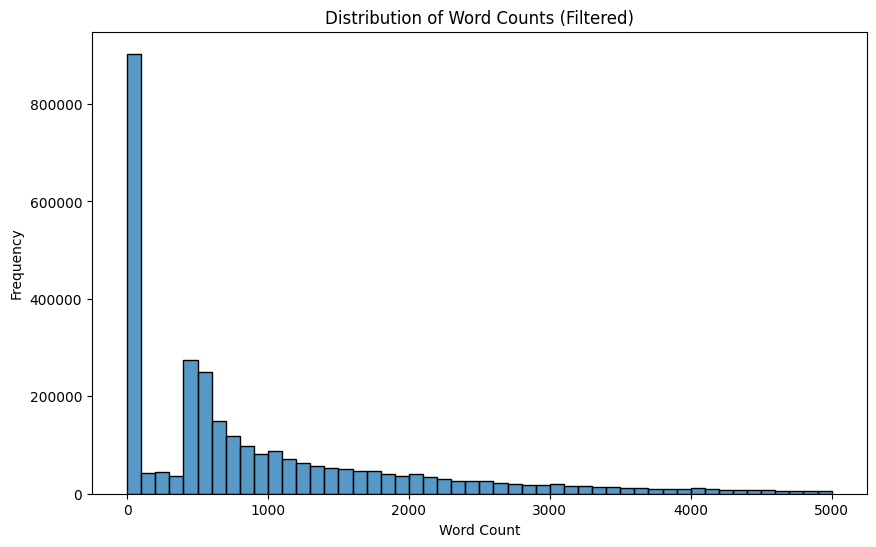

In [20]:
conn = mysql.connector.connect(**db_config)

query = "SELECT * FROM write_wordcount"
write_wordcount_df = pd.read_sql(query, conn)

conn.close()

# Remove the specified columns
columns_to_remove = ['time_goal', 'date_utc', 'updated_at']
write_wordcount_df.drop(columns=columns_to_remove, inplace=True)

# Check for duplicates
duplicates = write_wordcount_df[write_wordcount_df.duplicated()]
print(f"Number of duplicate rows in write_wordcount: {len(duplicates)}")

# If there are duplicates, remove them
if len(duplicates) > 0:
    write_wordcount_df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

# Display the first few rows of the dataset
print("write_wordcount")
print(write_wordcount_df.head())

# Basic statistics
print("\nBasic Statistics for write_wordcount:")
print(write_wordcount_df.describe())

# Check for missing values
print("\nMissing Values in write_wordcount:")
print(write_wordcount_df.isnull().sum())

# Set a threshold to filter out outliers
threshold = 5000  # Adjust this value as needed

# Filter the data
filtered_data = write_wordcount_df[write_wordcount_df['words'] <= threshold]

# Plot distribution of 'words' for the filtered data
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['words'], kde=False, bins=50)
plt.title('Distribution of Word Counts (Filtered)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


Chart 14: Distribution of Word Counts (Filtered)
Description:
This histogram shows the distribution of word counts in writing sessions, filtered to include word counts up to 5000 words. The x-axis represents the word count per session, and the y-axis represents the frequency of sessions with those word counts.

Analysis:
1. A sharp peak appears at the lower end of the histogram, indicating that most writing sessions have a very low word count (0-500 words). This implies that users write for brief periods of time on a regular basis.
2. There is a significant number of sessions with word counts close to zero, indicating that many users start a session but do not write much.
3. As the word count increases, the frequency of sessions decreases significantly. There are fewer sessions with higher word counts, indicating that users are less likely to engage in long writing sessions.

Insights:
1. Personalized Recommendations: Providing personalized writing prompts or feedback based on users' writing patterns can help sustain their interest and encourage more frequent writing.
2. Community Engagement: Setting up writing marathons or community challenges can motivate people to write more words and give them a sense of achievement.


## Correlation Analysis

In [21]:
db_config = {
    'user': 'analyst',
    'password': '!analyst#ftw*',
    'host': 'data-analysis.ftwcr.com',
    'database': 'app_main'
}

connection_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"
engine = create_engine(connection_string)

write_wordcount = pd.read_sql('SELECT * FROM write_wordcount', engine)
hero_daily_challenges = pd.read_sql('SELECT * FROM hero_daily_challenges', engine)
hero_areas = pd.read_sql('SELECT * FROM hero_areas', engine)

# Convert 'created_at' to datetime
write_wordcount['created_at'] = pd.to_datetime(write_wordcount['created_at'], errors='coerce')
hero_daily_challenges['created_at'] = pd.to_datetime(hero_daily_challenges['created_at'], errors='coerce')
hero_areas['created_at'] = pd.to_datetime(hero_areas['created_at'], errors='coerce')

# Sort and filter write_wordcount
write_wordcount_sorted = write_wordcount.sort_values(by='created_at', ascending=False)
write_wordcount_filtered = write_wordcount_sorted.head(500000)

# Sort and filter hero_daily_challenges
hero_daily_challenges_sorted = hero_daily_challenges.sort_values(by='created_at', ascending=False)
hero_daily_challenges_filtered = hero_daily_challenges_sorted.head(500000)

# Sort and filter hero_areas
hero_areas_sorted = hero_areas.sort_values(by='created_at', ascending=False)
hero_areas_filtered = hero_areas_sorted.head(100000)

# Function to rename conflicting columns
def rename_conflicting_columns(df, table_name):
    new_column_names = {col: f"{table_name}_{col}" for col in df.columns if col in ['created_at', 'updated_at']}
    return df.rename(columns=new_column_names)

# Rename columns in filtered dataframes
write_wordcount_filtered = rename_conflicting_columns(write_wordcount_filtered, 'write_wordcount')
hero_daily_challenges_filtered = rename_conflicting_columns(hero_daily_challenges_filtered, 'hero_daily_challenges')
hero_areas_filtered = rename_conflicting_columns(hero_areas_filtered, 'hero_areas')

# Print the number of rows to confirm
print(f"Number of rows in filtered write_wordcount: {write_wordcount_filtered.shape[0]}")
print(f"Number of rows in filtered hero_daily_challenges: {hero_daily_challenges_filtered.shape[0]}")
print(f"Number of rows in filtered hero_areas: {hero_areas_filtered.shape[0]}")


Number of rows in filtered write_wordcount: 500000
Number of rows in filtered hero_daily_challenges: 500000
Number of rows in filtered hero_areas: 100000


In [22]:
db_config = {
    'user': 'analyst',
    'password': '!analyst#ftw*',
    'host': 'data-analysis.ftwcr.com',
    'database': 'app_main'
}

connection_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"
engine = create_engine(connection_string)

app_users = pd.read_sql('SELECT * FROM app_users', engine)
hero_areas = pd.read_sql('SELECT * FROM hero_areas', engine)
hero_daily_challenges = pd.read_sql('SELECT * FROM hero_daily_challenges', engine)
hero_stats = pd.read_sql('SELECT * FROM hero_stats', engine)
payment_history = pd.read_sql('SELECT * FROM payment_history', engine)

# Display the initial number of rows in app_users
print(f"Initial number of rows in app_users: {app_users.shape[0]}")

# Rename columns to have a consistent key 'iduser' if necessary
app_users.rename(columns={'id': 'iduser', 'idhero': 'idhero'}, inplace=True)

# Create a mapping from idhero to iduser
id_map = app_users.set_index('idhero')['iduser'].to_dict()

# Function to replace idhero with iduser
def replace_idhero_with_iduser(df, idhero_col='idhero'):
    if idhero_col in df.columns:
        df['iduser'] = df[idhero_col].map(id_map)
        df.drop(columns=[idhero_col], inplace=True)
    return df

# Apply the function to replace idhero with iduser in other DataFrames
hero_areas = replace_idhero_with_iduser(hero_areas)
hero_daily_challenges = replace_idhero_with_iduser(hero_daily_challenges)
hero_stats = replace_idhero_with_iduser(hero_stats)

# Remove rows with missing iduser values in payment_history
payment_history_cleaned = payment_history.dropna(subset=['iduser'])

# Display the number of rows after removing missing iduser values in payment_history
print(f"Number of rows after removing missing iduser values in payment_history: {payment_history_cleaned.shape[0]}")

Initial number of rows in app_users: 68882
Number of rows after removing missing iduser values in payment_history: 106325


In [23]:
db_config = {
    'user': 'analyst',
    'password': '!analyst#ftw*',
    'host': 'data-analysis.ftwcr.com',
    'database': 'app_main'
}

connection_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"
engine = create_engine(connection_string)

app_users = pd.read_sql('SELECT * FROM app_users', engine)
hero_areas = pd.read_sql('SELECT * FROM hero_areas', engine)
hero_daily_challenges = pd.read_sql('SELECT * FROM hero_daily_challenges', engine)
hero_stats = pd.read_sql('SELECT * FROM hero_stats', engine)
payment_history = pd.read_sql('SELECT * FROM payment_history', engine)
app_user_apprentice_checklist = pd.read_sql('SELECT * FROM app_user_apprentice_checklist', engine)
app_user_checklist = pd.read_sql('SELECT * FROM app_user_checklist', engine)
write_streaks = pd.read_sql('SELECT * FROM write_streaks', engine)
write_wordcount = pd.read_sql('SELECT * FROM write_wordcount', engine)

# Display the initial number of rows in app_users
print(f"Initial number of rows in app_users: {app_users.shape[0]}")

# Rename columns in specific DataFrames
def rename_conflicting_columns(df, suffix):
    return df.rename(columns=lambda x: f"{x}_{suffix}" if x in ['created_at', 'updated_at'] else x)

app_user_apprentice_checklist = rename_conflicting_columns(app_user_apprentice_checklist, 'apprentice_checklist')
app_user_checklist = rename_conflicting_columns(app_user_checklist, 'user_checklist')
hero_stats = rename_conflicting_columns(hero_stats, 'hero_stats')
write_streaks = rename_conflicting_columns(write_streaks, 'write_streaks')

# Rename columns to have a consistent key 'iduser' if necessary
app_users.rename(columns={'id': 'iduser', 'idhero': 'idhero'}, inplace=True)

# Create a mapping from idhero to iduser
id_map = app_users.set_index('idhero')['iduser'].to_dict()

# Function to replace idhero with iduser
def replace_idhero_with_iduser(df, idhero_col='idhero'):
    if idhero_col in df.columns:
        df['iduser'] = df[idhero_col].map(id_map)
        df.drop(columns=[idhero_col], inplace=True)
    return df

# Apply the function to replace idhero with iduser in other DataFrames
hero_areas = replace_idhero_with_iduser(hero_areas)
hero_daily_challenges = replace_idhero_with_iduser(hero_daily_challenges)
hero_stats = replace_idhero_with_iduser(hero_stats)

# Remove rows with missing iduser values in payment_history
payment_history_cleaned = payment_history.dropna(subset=['iduser'])

# Display the number of rows after removing missing iduser values in payment_history
print(f"Number of rows after removing missing iduser values in payment_history: {payment_history_cleaned.shape[0]}")

Initial number of rows in app_users: 68882
Number of rows after removing missing iduser values in payment_history: 106325


In [24]:
merged_df = app_users.rename(columns={'id': 'iduser', 'idhero': 'idhero'})

# Merge with app_user_apprentice_checklist
if 'iduser' in app_user_apprentice_checklist.columns:
    merged_df = merged_df.merge(app_user_apprentice_checklist, on='iduser', how='left')


In [25]:
# Merge with app_user_checklist
if 'iduser' in app_user_checklist.columns:
    merged_df = merged_df.merge(app_user_checklist, on='iduser', how='left')


In [26]:
# Merge with hero_stats
if 'iduser' in hero_stats.columns:
    merged_df = merged_df.merge(hero_stats, on='iduser', how='left')


In [27]:
# Merge with write_streaks
if 'iduser' in write_streaks.columns:
    merged_df = merged_df.merge(write_streaks, on='iduser', how='left')


In [28]:
# Merge with write_wordcount_filtered
if 'iduser' in write_wordcount_filtered.columns:
    merged_df = merged_df.merge(write_wordcount_filtered, on='iduser', how='left')


In [29]:
# Merge with hero_areas
if 'iduser' in hero_areas_filtered.columns:
    merged_df = merged_df.merge(hero_areas_filtered, on='iduser', how='left')


In [30]:
# Merge with hero_daily_challenges
if 'iduser' in hero_daily_challenges_filtered.columns:
    merged_df = merged_df.merge(hero_daily_challenges_filtered, on='iduser', how='left')


In [31]:
# Aggregate payment_history and merge
if 'iduser' in payment_history_cleaned.columns:
    payment_history_agg = payment_history_cleaned.groupby('iduser')['amount'].sum().reset_index()
    merged_df = merged_df.merge(payment_history_agg, on='iduser', how='left')


In [32]:
subscription_status_mapping = {'unconverted': 0, 'trial': 0, 'subscriber': 1, 'expired': 1}
merged_df['subscription_status_numeric'] = merged_df['subscription_status'].map(subscription_status_mapping)

In [33]:
for col in merged_df.columns:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

In [34]:
# Remove rows that do not have any values
merged_df.dropna(how='all', inplace=True)

# Columns to drop
columns_to_drop = [
    'created_at', 'created_at_apprentice_checklist', 'updated_at_apprentice_checklist',
    'updated_at_user_checklist', 'created_at_user_checklist', 'start_date',
    'end_date', 'date', 'date_utc', 'write_wordcount_created_at', 'write_wordcount_updated_at', 'hero_areas_created_at',
    'hero_areas_updated_at', 'freeze_until', 'freeze_cost', 'freeze_relation', 'freeze_origin',
    'referred_by', 'expires_at', 'status', 'subscription_status', 'steps', 'avatar_lg', 'avatar_md', 'avatar_sm', 'avatar_xs', 'movement', 'item1', 'item2', 'item3', 'minerware', 'active_x', 'in_use', 'avatarslot1', 'avatarslot2', 'avatarslot3', 'reward', 'idheroarea', 'idarea', 'idhero_y', 'active_y', 'step', 'unlocked', 'introduction_y'
]

merged_df.drop(columns=columns_to_drop, inplace=True)

num_rows = merged_df.shape[0]
print(f"Number of rows in the merged dataframe: {num_rows}")

print(merged_df.head())

Number of rows in the merged dataframe: 7992750
   iduser  idhero_x  idchallenge      id  tear  completed  idbodytype  level    exp  attack  \
0       1         1          NaN  6219.0   0.0        0.0         1.0    1.0    0.0     0.0   
1      14      3799          NaN     NaN   NaN        NaN         2.0    3.0  228.0     0.0   
2      14      3799          NaN     NaN   NaN        NaN         2.0    3.0  228.0     0.0   
3      14      3799          NaN     NaN   NaN        NaN         2.0    3.0  228.0     0.0   
4      21      3804          NaN     NaN   NaN        NaN         1.0    1.0   25.0     0.0   

   defense  luck  head  chest  feet  weapon1  weapon2  accessory  current_area  avatarslotinuse  \
0      0.0   0.0   NaN    NaN   NaN      NaN      NaN        NaN           1.0              1.0   
1      0.0   0.0   NaN    NaN   NaN      NaN      NaN        NaN           1.0              1.0   
2      0.0   0.0   NaN    NaN   NaN      NaN      NaN        NaN           1.0      

In [35]:
correlation_matrix = merged_df.corr()

# Get correlations with subscription_status_numeric
subscription_correlations = correlation_matrix['subscription_status_numeric'].drop('subscription_status_numeric').sort_values(ascending=False)

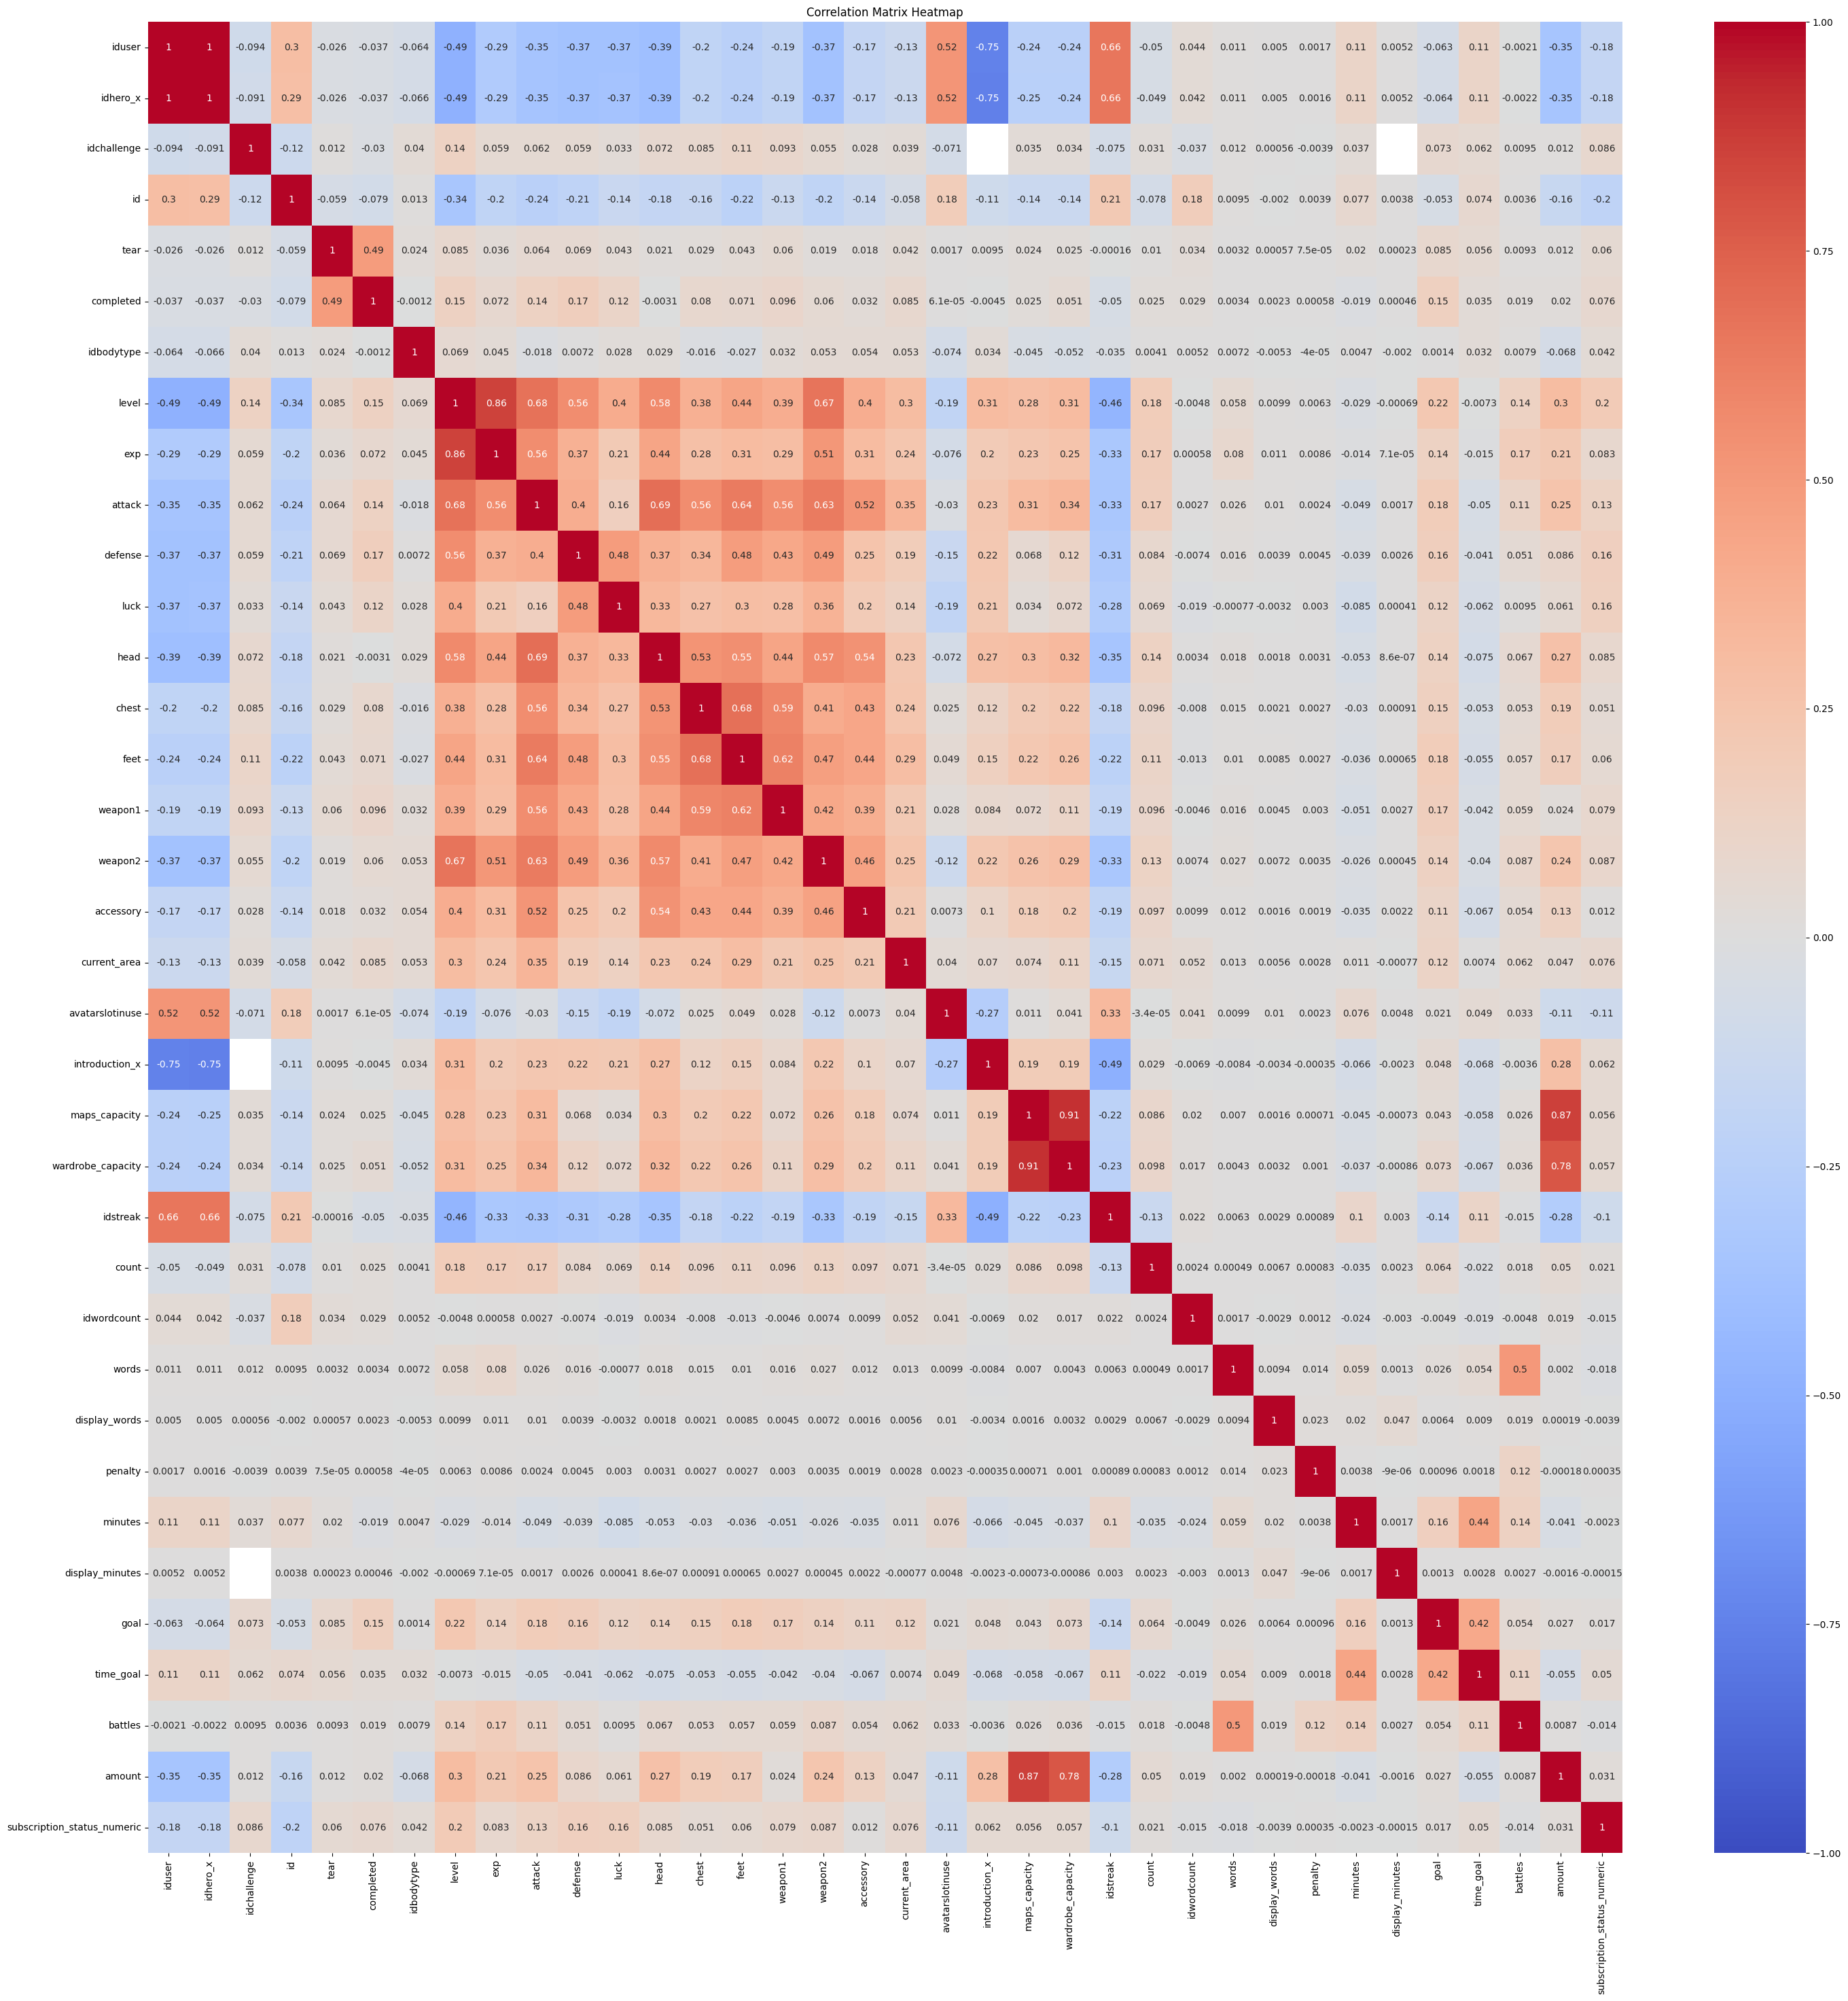

In [36]:
plt.figure(figsize=(35, 35))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.savefig('sample_bar_plot.png', bbox_inches='tight')
plt.show()

In [37]:
subscription_correlations = correlation_matrix['subscription_status_numeric'].drop('subscription_status_numeric').sort_values(ascending=False)

print("Correlations with subscription_status_numeric:")
print(subscription_correlations.head(36))

Correlations with subscription_status_numeric:
level                0.197234
defense              0.158450
luck                 0.155347
attack               0.128247
weapon2              0.087491
idchallenge          0.085647
head                 0.085482
exp                  0.083453
weapon1              0.078510
current_area         0.076359
completed            0.075680
introduction_x       0.062309
feet                 0.059915
tear                 0.059729
wardrobe_capacity    0.057269
maps_capacity        0.056128
chest                0.050817
time_goal            0.049593
idbodytype           0.042333
amount               0.030724
count                0.020639
goal                 0.017355
accessory            0.011947
penalty              0.000352
display_minutes     -0.000155
minutes             -0.002252
display_words       -0.003940
battles             -0.013993
idwordcount         -0.014880
words               -0.018452
idstreak            -0.102150
avatarslotinuse     -0.

Top 5 Positive Correlation:
As far as positive relationships are concerned, although none of the variables have a relationship coefficient of 0.2 or more, there is still some valuable information here.
level (0.197234): A moderate positive correlation indicates that the higher the level, the more likely the users are to be subscribers.

defense (0.158450): A moderate positive correlation indicates that users with higher defense stats are more likely to be subscribers.

luck (0.155347): A moderate positive correlation indicates that users with higher luck stats are more likely to be subscribers.

attack (0.128247): A moderate positive correlation indicates that users with higher attack stats are more likely to be subscribers.

weapon2 (0.087491): A weak positive correlation indicates that users with higher second weapon stats are more likely to be subscribers.

Top 3 Negative Correlation:
Since variables like id, iduser, idhero_x, idstreak, idwordcount are just for the user's identity, those variables will be ignored for the analysis.

avatarslotinuse (-0.114566): A negative correlation indicates that users who have more avatar slots in use are slightly less likely to subscribe.

words (-0.018452): A weak negative correlation indicates that users who write more words are slightly less likely to subscribe.

battles (-0.013993): A weak negative correlation indicates that users who participate in more battles are slightly less likely to subscribe.

Analysis:
Based on these eight correlations, I think there are a number of things that 4thewords can do. Firstly, in terms of positive relationships, 4thewords can increase the speed or decrease the difficulty of levelling up while at the same time giving the user more comprehensive equipment to give them a greater advantage in subsequent monster battles. Secondly, on the negative side, 4thewords can get customers to engage in writing as much as possible and get them to focus on writing efficiently in a short period of time and making subsequent monster battles less difficult, such as lowering the number of words or the amount of time needed to defeat a monster.


# Data Modelling

In [38]:
# Database configuration
db_config = {
    'user': 'analyst',
    'password': '!analyst#ftw*',
    'host': 'data-analysis.ftwcr.com',
    'database': 'app_main'
}

# Create a connection to the database
connection_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"
engine = create_engine(connection_string)

# Load datasets
app_users = pd.read_sql('SELECT id AS iduser, idhero, created_at, subscription_status FROM app_users', engine)
write_wordcount = pd.read_sql('SELECT * FROM write_wordcount', engine)
hero_daily_challenges = pd.read_sql('SELECT id AS iduser, iddailychallenge, created_at FROM hero_daily_challenges', engine)
write_streaks = pd.read_sql('SELECT iduser, Count FROM write_streaks', engine)

# Ensure datetime format
app_users['created_at'] = pd.to_datetime(app_users['created_at'], errors='coerce')
write_wordcount['created_at'] = pd.to_datetime(write_wordcount['created_at'], errors='coerce')
hero_daily_challenges['created_at'] = pd.to_datetime(hero_daily_challenges['created_at'], errors='coerce')

## Step 1: Write over 100 words on the first day

In [39]:
# Merge app_users with write_wordcount to track writing activity
merged_df = app_users.merge(write_wordcount, on='iduser', how='left')

# Filter to get writing activity on the first day after account creation
first_day_writing = merged_df[merged_df['created_at_y'].dt.date == merged_df['created_at_x'].dt.date]

# Group by user and sum the words written on the first day
first_day_writing = first_day_writing.groupby('iduser')['words'].sum().reset_index()

# Create a binary feature indicating whether the user wrote more than 100 words on their first day
first_day_writing['wrote_over_100_words_first_day'] = first_day_writing['words'] > 100

# Merge this feature back into the main dataframe
app_users = app_users.merge(first_day_writing[['iduser', 'wrote_over_100_words_first_day']], on='iduser', how='left')

# Fill NaN values for users who did not write on the first day with False
app_users['wrote_over_100_words_first_day'] = app_users['wrote_over_100_words_first_day'].fillna(False).astype(int)

## Step 2: Either write over 200 words or engage in four or more battles on two active days within the first five days

In [40]:
merged_df = app_users.merge(write_wordcount, on='iduser', how='left', suffixes=('', '_write'))
merged_df = merged_df.merge(hero_daily_challenges, on='iduser', how='left', suffixes=('', '_battle'))

# Calculate days since signup for both writing and battle activities
merged_df['days_since_signup_write'] = (merged_df['created_at_write'] - merged_df['created_at']).dt.days
merged_df['days_since_signup_battle'] = (merged_df['created_at_battle'] - merged_df['created_at']).dt.days

activity_within_five_days = merged_df[((merged_df['days_since_signup_write'] >= 0) & (merged_df['days_since_signup_write'] <= 5)) |
                                      ((merged_df['days_since_signup_battle'] >= 0) & (merged_df['days_since_signup_battle'] <= 5))]

# Create a feature to identify active days based on writing words or battles
activity_within_five_days['active_day'] = (activity_within_five_days['words'] > 200) | (activity_within_five_days['iddailychallenge'].isin([8, 9, 10, 11, 12]))

# Group by user and sum the active days
active_days_count = activity_within_five_days.groupby('iduser')['active_day'].sum().reset_index()

# Create a binary feature indicating whether the user met the conditions on at least two active days within the first five days
active_days_count['two_active_days_within_five_days'] = active_days_count['active_day'] >= 2

# Merge back
app_users = app_users.merge(active_days_count[['iduser', 'two_active_days_within_five_days']], on='iduser', how='left')

app_users['two_active_days_within_five_days'] = app_users['two_active_days_within_five_days'].fillna(False).astype(int)

<ipython-input-40-1b6a159efdda>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activity_within_five_days['active_day'] = (activity_within_five_days['words'] > 200) | (activity_within_five_days['iddailychallenge'].isin([8, 9, 10, 11, 12]))


## Step 3: Be active for five consecutive days at any point during the trial

In [41]:
# Sort write_streaks by iduser and variable Count
write_streaks_sorted = write_streaks.sort_values(by=['iduser', 'Count'], ascending=[True, True])

# Drop duplicates to keep only the first occurrence of a five-day streak or more
first_five_day_streak = write_streaks_sorted[write_streaks_sorted['Count'] >= 5].drop_duplicates(subset='iduser', keep='first')
first_five_day_streak['has_five_day_streak'] = True

# Merge back
app_users = app_users.merge(first_five_day_streak[['iduser', 'has_five_day_streak']], on='iduser', how='left')

# Fill NaN values for users who did not have any streaks with False
app_users['has_five_day_streak'] = app_users['has_five_day_streak'].fillna(False).astype(int)


In [42]:
print(app_users.head())
print(f"Number of rows: {app_users.shape[0]}")
print(f"Number of columns: {app_users.shape[1]}")

   iduser  idhero          created_at subscription_status  wrote_over_100_words_first_day  \
0       1       1 2017-12-07 22:55:35          subscriber                               0   
1      14    3799 2017-03-16 09:13:53         unconverted                               0   
2      21    3804 2016-05-16 09:13:53         unconverted                               0   
3      22    3805 2016-05-16 09:13:53          subscriber                               0   
4      28      28 2016-05-16 09:13:53          subscriber                               1   

   two_active_days_within_five_days  has_five_day_streak  
0                                 0                    0  
1                                 0                    0  
2                                 0                    0  
3                                 0                    1  
4                                 1                    1  
Number of rows: 68882
Number of columns: 7


## Ensure the dataframe app_users is ready to use

In [43]:
# Check for missing values
missing_values = app_users.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 iduser                              0
idhero                              0
created_at                          0
subscription_status                 0
wrote_over_100_words_first_day      0
two_active_days_within_five_days    0
has_five_day_streak                 0
dtype: int64


In [44]:
# Check data types
data_types = app_users.dtypes
print("Data types of each column:\n", data_types)

Data types of each column:
 iduser                                       int64
idhero                                       int64
created_at                          datetime64[ns]
subscription_status                         object
wrote_over_100_words_first_day               int64
two_active_days_within_five_days             int64
has_five_day_streak                          int64
dtype: object


In [45]:
# Describe the numeric features
numeric_summary = app_users.describe()
print("Summary statistics of numeric features:\n", numeric_summary)

# Display the distribution of binary features
binary_features = ['wrote_over_100_words_first_day', 'two_active_days_within_five_days', 'has_five_day_streak']
for feature in binary_features:
    print(f"\nDistribution of {feature}:\n", app_users[feature].value_counts(normalize=True))


Summary statistics of numeric features:
              iduser        idhero                     created_at  wrote_over_100_words_first_day  \
count  68882.000000  68882.000000                          68882                    68882.000000   
mean   35821.185375  36942.607575  2021-01-09 04:07:52.048024320                        0.438199   
min        1.000000      1.000000            2016-05-16 09:13:53                        0.000000   
25%    17821.250000  19088.250000     2018-10-05 23:13:29.500000                        0.000000   
50%    35748.500000  37019.500000     2021-05-10 13:35:56.500000                        0.000000   
75%    53480.750000  54757.750000  2023-05-29 02:05:57.249999872                        1.000000   
max    73026.000000  72473.000000            2024-05-20 10:37:11                        1.000000   
std    20769.123226  20516.051656                            NaN                        0.496169   

       two_active_days_within_five_days  has_five_day_stre

## Model Training

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import resample

# Convert the subscription status to numeric
app_users['subscription_status_numeric'] = app_users['subscription_status'].map({'unconverted': 0, 'trial': 0, 'subscribed': 1, 'expired': 1})

# Check the distribution of the target variable
print(app_users['subscription_status_numeric'].value_counts())

# Separate the majority and minority classes
df_majority = app_users[app_users['subscription_status_numeric'] == 0]
df_minority = app_users[app_users['subscription_status_numeric'] == 1]

# Upsample the minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

# Combine majority class with upsampled minority class
app_users_upsampled = pd.concat([df_majority, df_minority_upsampled])

print(app_users_upsampled['subscription_status_numeric'].value_counts())

# Define the target variable and selected features
target = 'subscription_status_numeric'
selected_features = ['has_five_day_streak', 'wrote_over_100_words_first_day', 'two_active_days_within_five_days']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(app_users_upsampled[selected_features], app_users_upsampled[target], test_size=0.3, random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', max_depth=None, min_samples_split=2),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, learning_rate=0.01, max_depth=3, random_state=42)
}

# Train the models with class weights
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained.')

# Evaluate the models with class weights
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f'Evaluation for {name}:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision: {precision_score(y_test, y_pred):.4f}')
    print(f'Recall: {recall_score(y_test, y_pred):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')
    print(f'AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}')
    print('-' * 30)

    print(f'Probability Predictions for {name}:')
    print(y_prob[:10])

    print(f'Predictions for {name}:')
    print(y_pred[:10])

subscription_status_numeric
0.0    58612
1.0     7055
Name: count, dtype: int64
subscription_status_numeric
0.0    58612
1.0    58612
Name: count, dtype: int64
Logistic Regression trained.
Random Forest trained.
Gradient Boosting trained.
Evaluation for Logistic Regression:
Accuracy: 0.8123
Precision: 0.9167
Recall: 0.6846
F1 Score: 0.7838
AUC-ROC: 0.8654
------------------------------
Probability Predictions for Logistic Regression:
[0.16672135 0.47203349 0.94503671 0.47203349 0.16672135 0.16672135
 0.16672135 0.16672135 0.94503671 0.94503671]
Predictions for Logistic Regression:
[0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
Evaluation for Random Forest:
Accuracy: 0.8157
Precision: 0.7954
Recall: 0.8472
F1 Score: 0.8205
AUC-ROC: 0.8706
------------------------------
Probability Predictions for Random Forest:
[0.14163035 0.51415168 0.91631315 0.51415168 0.14163035 0.14163035
 0.14163035 0.14163035 0.91631315 0.91631315]
Predictions for Random Forest:
[0. 1. 1. 1. 0. 0. 0. 0. 1. 1.]
Evaluation for Gr

## Feature Importance for Random Forest and Gradient Boosting

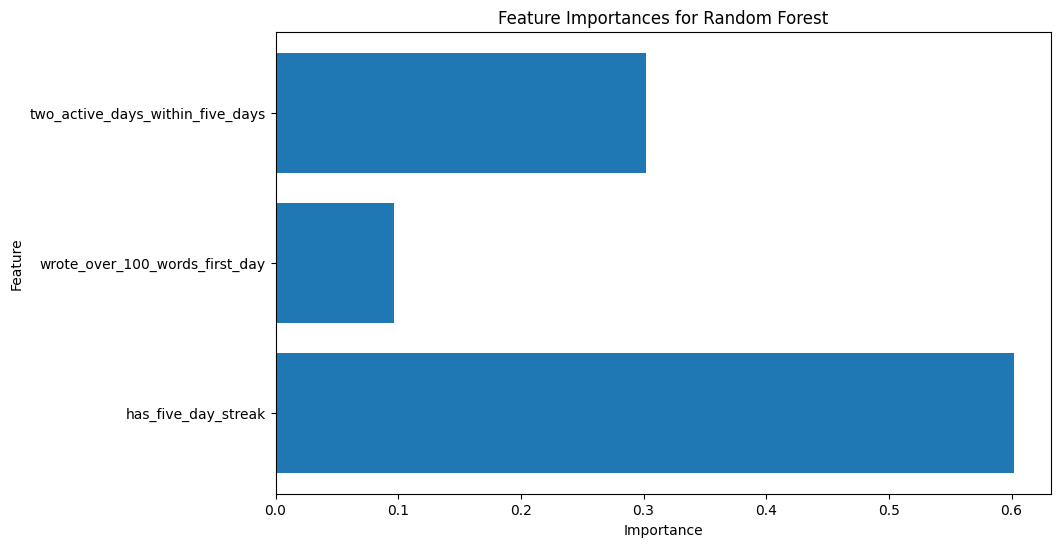

In [47]:
feature_importances = models['Random Forest'].feature_importances_
feature_names = selected_features
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest')
plt.show()

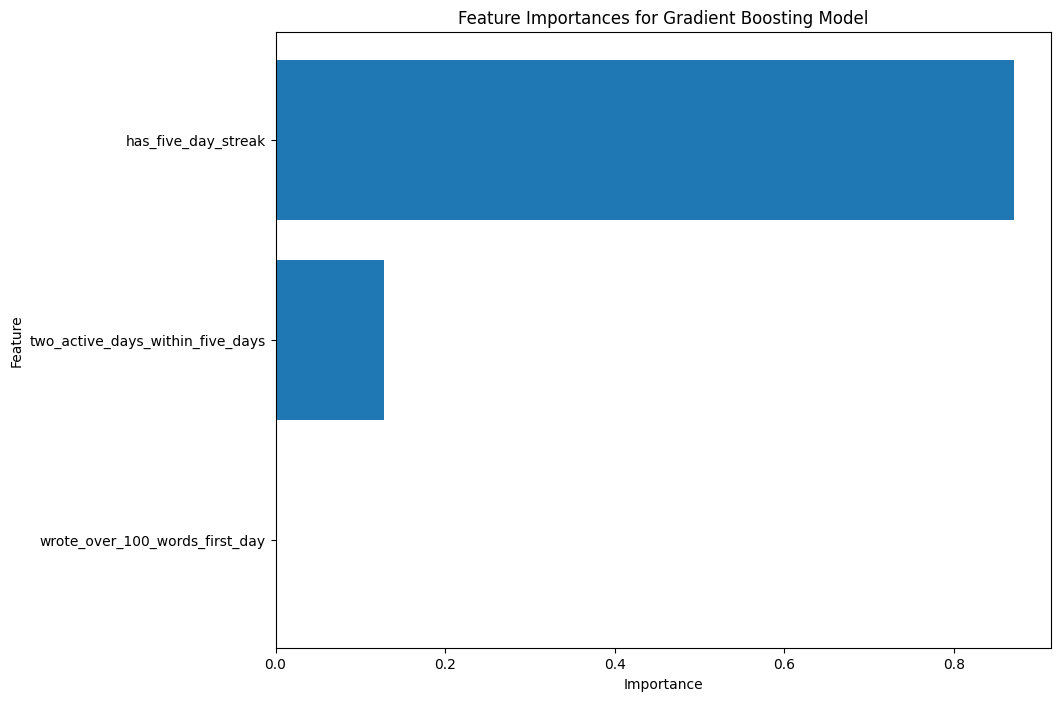

In [48]:
# Train the Gradient Boosting Model
gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=50)
gb_model.fit(X_train, y_train)

# Get feature importances
feature_importances = gb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Gradient Boosting Model')
plt.gca().invert_yaxis()
plt.show()


## Cross Validation

In [49]:
# Logistic Regression
log_reg = models['Logistic Regression']
log_reg_cv_scores = cross_val_score(log_reg, app_users_upsampled[selected_features], app_users_upsampled[target], cv=5, scoring='accuracy')
print(f'Logistic Regression Cross-Validation Accuracy: {log_reg_cv_scores.mean():.4f}')

# Random Forest
rf = models['Random Forest']
rf_cv_scores = cross_val_score(rf, app_users_upsampled[selected_features], app_users_upsampled[target], cv=5, scoring='accuracy')
print(f'Random Forest Cross-Validation Accuracy: {rf_cv_scores.mean():.4f}')

# Gradient Boosting
gb = models['Gradient Boosting']
gb_cv_scores = cross_val_score(gb, app_users_upsampled[selected_features], app_users_upsampled[target], cv=5, scoring='accuracy')
print(f'Gradient Boosting Cross-Validation Accuracy: {gb_cv_scores.mean():.4f}')


Logistic Regression Cross-Validation Accuracy: 0.8150
Random Forest Cross-Validation Accuracy: 0.8108
Gradient Boosting Cross-Validation Accuracy: 0.8108


Fine-tuning

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

param_grid_log_reg = {
    'C': [0.1, 1],
    'solver': ['liblinear']
}

param_grid_rand_forest = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

param_grid_grad_boost = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1],
    'max_depth': [3]
}

# Initialize models
log_reg = LogisticRegression(max_iter=100, class_weight='balanced')
rand_forest = RandomForestClassifier(random_state=42, class_weight='balanced')
grad_boost = GradientBoostingClassifier(random_state=42)

# Perform GridSearchCV for Logistic Regression
grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=3, scoring='roc_auc')
grid_search_log_reg.fit(X_train, y_train)
best_log_reg = grid_search_log_reg.best_estimator_
print('Best parameters for Logistic Regression:', grid_search_log_reg.best_params_)

# Perform GridSearchCV for Random Forest
grid_search_rand_forest = GridSearchCV(rand_forest, param_grid_rand_forest, cv=3, scoring='roc_auc')
grid_search_rand_forest.fit(X_train, y_train)
best_rand_forest = grid_search_rand_forest.best_estimator_
print('Best parameters for Random Forest:', grid_search_rand_forest.best_params_)

# Perform GridSearchCV for Gradient Boosting
grid_search_grad_boost = GridSearchCV(grad_boost, param_grid_grad_boost, cv=3, scoring='roc_auc')
grid_search_grad_boost.fit(X_train, y_train)
best_grad_boost = grid_search_grad_boost.best_estimator_
print('Best parameters for Gradient Boosting:', grid_search_grad_boost.best_params_)

# Evaluate the models with best parameters
models = {
    'Logistic Regression': best_log_reg,
    'Random Forest': best_rand_forest,
    'Gradient Boosting': best_grad_boost
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f'Evaluation for {name}:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision: {precision_score(y_test, y_pred):.4f}')
    print(f'Recall: {recall_score(y_test, y_pred):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')
    print(f'AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}')
    print('-' * 30)

Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Evaluation for Logistic Regression:
Accuracy: 0.8123
Precision: 0.9167
Recall: 0.6846
F1 Score: 0.7838
AUC-ROC: 0.8654
------------------------------
Evaluation for Random Forest:
Accuracy: 0.8157
Precision: 0.7954
Recall: 0.8472
F1 Score: 0.8205
AUC-ROC: 0.8706
------------------------------
Evaluation for Gradient Boosting:
Accuracy: 0.8157
Precision: 0.7954
Recall: 0.8472
F1 Score: 0.8205
AUC-ROC: 0.8706
------------------------------
